In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler


In [3]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


# Z-transform adata

In [3]:
sc.pp.scale(adata, max_value=10)

## Read features

In [4]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [5]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,19,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,5,3
other_T,247,112


## SVM (test)

In [6]:
celltype = 'B'
# subset data to celltype features
X = adata[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in adata.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced', max_iter=5000)
# OvR (one-vs-rest) decision function
# class_weight='balanced': Useful for imbalanced datasets, as it gives higher penalties to the minority class. Avoid bias toward the majority class
svm_clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = svm_clf.predict(X_test)
# y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
metrics

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.9993509102710723,
 0.9931580842635938,
 0.9992753623188406,
 0.9962073324905184,
 0.9993166592961419,
 0.99250022256181,
 0.9958580338565541]

## Stratified K-fold

In [7]:
import pickle

def SVM_strat_KFold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    print('Fitting SVM model...')
    svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced', max_iter=10000)
    # OvR (one-vs-rest) decision function
    # class_weight='balanced': Useful for imbalanced datasets, as it gives higher penalties to the minority class. Avoid bias toward the majority class
    svm_clf.fit(X_train, y_train)

    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score),
    'mcc': make_scorer(matthews_corrcoef)
    }

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_results = cross_validate(svm_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)
    # return cv_results

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_pr_auc'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return svm_clf, mean_metrics, cv_results




In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\SVM_model')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/SVM_model')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
cv_results_dict = {}
# likelihood_dict = {}
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics, cv_results = SVM_strat_KFold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Record CV results fold-by-fold
    cv_results_dict[celltype] = cv_results

    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output SVM model as pickle
    filename = f'SVM_{celltype}_linear_StardardScale_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)

    # likelihood of the positive class for each observation
    # likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    # print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個
    # likelihood_dict[celltype] = likelihood


K-fold CV for: B
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9994204505236086, 0.9945896991988828, 0.9986413043478262, 0.9966104315894961, 0.9990672111844218, 0.9933535364356884, 0.9962966005956014]
K-fold CV for: CD4_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.7193193029866143, 0.5111295396984468, 0.7154613644558943, 0.5903346372588953, 0.7180453494466615, 0.4590606880395984, 0.4053896263876524]
K-fold CV for: CD8_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.7688142942122649, 0.3929691206300655, 0.8287116564417178, 0.5320333304622017, 0.7931666853379256, 0.3529447761138479, 0.45446560717629725]
K-fold CV for: DC
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.995464063089679, 0.834457974071755, 0.9926847447356459, 0.906683748121992, 0.994105925394534, 0.8285340293281556, 0.907978435064756]
K-fold CV for: Mono
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9915308533117961, 0.9750729574526374, 0.9975515278946412, 0.9861834835953374, 0.9932327006046586, 0.973429043090509, 0.9802116929008537]
K-fold CV for: NK
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross validation...
[0.9795998863156182, 0.8613422777533721, 0.9817168883872982, 0.917468093611677, 0.9805203938791838, 0.8476448930169926, 0.9084978377142467]
K-fold CV for: other
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.015663322563657746, 0.008183111118922577, 0.3755202111862729, 0.016017140649828725, 0.19168006168273688, 0.016562543228014672, -0.679606752022707]
K-fold CV for: other_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9313350176726717, 0.277580526720081, 0.28540646956073873, 0.2717182488594552, 0.622518527569529, 0.11153654474293395, 0.24176486597044006]


In [9]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999420,0.994590,0.998641,0.996610,0.999067,0.993354,0.996297
CD4_T,0.719319,0.511130,0.715461,0.590335,0.718045,0.459061,0.405390
CD8_T,0.768814,0.392969,0.828712,0.532033,0.793167,0.352945,0.454466
DC,0.995464,0.834458,0.992685,0.906684,0.994106,0.828534,0.907978
Mono,0.991531,0.975073,0.997552,0.986183,0.993233,0.973429,0.980212
NK,0.979600,0.861342,0.981717,0.917468,0.980520,0.847645,0.908498
other,0.015663,0.008183,0.375520,0.016017,0.191680,0.016563,-0.679607
other_T,0.931335,0.277581,0.285406,0.271718,0.622519,0.111537,0.241765


In [10]:
!cd

C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\SVM_model


In [11]:
all_metrics.to_csv('SVM_metrics_linear_StandardScale_l1.csv')

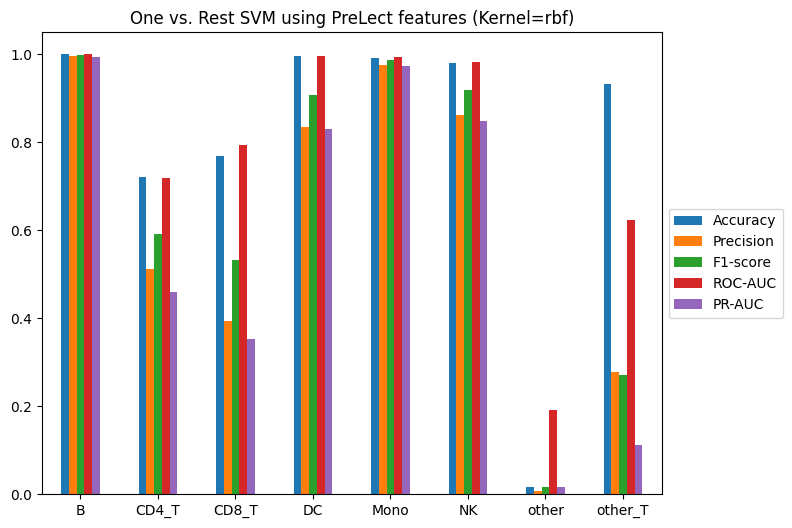

In [13]:
# Plot metrics for each celltype
cols = ['Accuracy', 'Precision', 'F1-score', 'ROC-AUC', 'PR-AUC']
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest SVM using PreLect features (Kernel=rbf)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [17]:
# Recursive function to convert np.array to list
def convert_arrays_to_lists(data):
    if isinstance(data, dict):
        return {key: convert_arrays_to_lists(value) for key, value in data.items()}
    elif isinstance(data, np.ndarray):
        return data.tolist()
    else:
        return data

# Convert all np.array elements in the dictionary to lists
dict_converted = convert_arrays_to_lists(cv_results_dict)
dict_converted

{'B': {'fit_time': [1.5630090236663818,
   1.4978959560394287,
   1.5670104026794434,
   1.6266050338745117,
   1.5058956146240234],
  'score_time': [0.12714004516601562,
   0.11970901489257812,
   0.12714004516601562,
   0.13212847709655762,
   0.12170863151550293],
  'test_accuracy': [0.9994977398292315,
   0.9993818097519511,
   0.9995363573139634,
   0.9993431728614481,
   0.9993431728614481],
  'test_precision': [0.9959331224582015,
   0.9954792043399638,
   0.9954873646209387,
   0.9928025191183086,
   0.9932462854570013],
  'test_recall': [0.9981884057971014,
   0.9972826086956522,
   0.9990942028985508,
   0.9995471014492754,
   0.9990942028985508],
  'test_f1': [0.9970594888034382,
   0.9963800904977376,
   0.9972875226039785,
   0.9961633942676598,
   0.996161661774667],
  'test_roc_auc': [0.9989041289809161,
   0.998430102185116,
   0.9993358992865652,
   0.9994356272643015,
   0.9992302982052101],
  'test_pr_auc': [0.9942834373780873,
   0.9930059191494497,
   0.99466292883

In [18]:
import json
with open('SVM_KFold_linear_l1.json', 'w') as f:
    json.dump(dict_converted, f)

In [ ]:
# turn likelihood_dict into dataframe
# likelihood_df = pd.DataFrame(likelihood_dict)
# likelihood_df.head()

## Evaluate by DEGn

In [ ]:
count_df

In [6]:
# Read DEG table
# os.chdir("/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table")
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\L1_DEG\L1_DEG_table")
os.chdir(home_path / 'Source_code_supplementary/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table')

# celltype = 'B'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
# n_features = count_df.loc[celltype, 'Feature_count']  # 3902
# DEGn = DEG_table['names'][:n_features].tolist()

In [9]:
def SVM_classifier_DEG(data, DEGn, celltype):
    # subset data to celltype features
    X = data[:, DEGn].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced')
    svm_clf.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = svm_clf.predict(X_test)
    # y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
    return svm_clf, metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist() 
    clf, celltype_metrics = SVM_classifier_DEG(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics